In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install -q transformers
!pip install -q spacy
!pip install -q sentencepiece
!pip install -q bert-extractive-summarizer
!pip install -q bertopic
!pip install -q top2vec[sentence_transformer]
!pip install -q top2vec[sentence_encoders]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 19.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 77.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 22.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 49.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 120.7/120.7 kB 10.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 10.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.2/88.2 kB 8.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 69.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 63.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━

In [3]:
import os,shutil,glob
from tqdm import tqdm
import pandas as pd
import numpy as np
import re
import random

import tensorflow as tf
import torch

np.random.seed(42)
tf.random.set_seed(42)
torch.manual_seed(42)
random.seed(42)

In [4]:
directory = "/content/drive/MyDrive/Transcription"

In [5]:
teams,datas = [],[]
for file in os.listdir(directory):
    if file.endswith("txt") :
        file_path = os.path.join(directory, file)
        with open(file_path, "r") as f:
            text_doc = f.read()
            text_doc = re.sub(r'\n\n',' ',text_doc)
            team = file.split(".")[0]
            teams.append(team)
            datas.append(text_doc)
            
df = pd.DataFrame(columns=["Filenames","Texts"])
df["Filenames"] = np.array(teams)
df["Texts"] = np.array(datas)
df.head()

,Filenames,Texts
0,Audio A,"Good morning, scholars. Good morning, everyone..."
1,Audio B,Maybe it's the school system that's making the...
2,Audio C,Surgery she's coming in for the capra tunnel. ...
3,Audio D,"Alright, so when you walked in this morning, y..."
4,Audio E,We've talked a lot this year about praise vers...


**BERTTopic**

In [6]:
from bertopic import BERTopic
from sklearn.preprocessing import MaxAbsScaler
from umap import UMAP
import plotly.graph_objs as go

documents = df['Texts'].tolist()
bertopic_model = BERTopic(min_topic_size=2, n_gram_range=(1,6))
topics, probs = bertopic_model.fit_transform(documents)

if len(topics) > 0:
    all_topics = sorted(list(bertopic_model.get_topics().keys()))
    indices = [all_topics.index(topic) for topic in topics]
    embeddings = bertopic_model.c_tf_idf_[indices]
    embeddings = MaxAbsScaler().fit_transform(embeddings)
    embeddings = UMAP(n_neighbors=2, n_components=2, metric='hellinger', random_state=42).fit_transform(embeddings)

    layout = go.Layout(title='UMAP projection of BERTopic clusters', width=800, height=600)
    fig = go.Figure(layout=layout)
    for i in range(len(topics)):
        fig.add_trace(go.Scatter(x=[embeddings[i, 0]], y=[embeddings[i, 1]], mode='markers', marker=dict(size=probs[i]*50), name=topics[i]))
    fig.update_layout(title="UMAP Projection", xaxis_title='UMAP Component 1', yaxis_title='UMAP Component 2')
    fig.show()
else:
    print("No topics were found.")

In [7]:
df1 = df.copy(deep=True)
documents = df1['Texts'].tolist()
bertopic_model = BERTopic(min_topic_size=2, n_gram_range=(1,6))
topics, probs = bertopic_model.fit_transform(documents)

def predict_topic(text):
    topic, _ = bertopic_model.transform([text])
    return topic[0]

df1['Topics'] = df['Texts'].apply(predict_topic)
df1 = df1[["Filenames","Texts","Topics"]]
df1.head()

,Filenames,Texts,Topics
0,Audio A,"Good morning, scholars. Good morning, everyone...",-1
1,Audio B,Maybe it's the school system that's making the...,-1
2,Audio C,Surgery she's coming in for the capra tunnel. ...,-1
3,Audio D,"Alright, so when you walked in this morning, y...",-1
4,Audio E,We've talked a lot this year about praise vers...,-1


**Top2Vec + Distriluse-base-multilingual-cased**

2023-04-26 07:08:02,999 - top2vec - INFO - Pre-processing documents for training
INFO:top2vec:Pre-processing documents for training
2023-04-26 07:08:03,125 - top2vec - INFO - Downloading distiluse-base-multilingual-cased model
INFO:top2vec:Downloading distiluse-base-multilingual-cased model


2023-04-26 07:08:11,602 - top2vec - INFO - Creating joint document/word embedding
INFO:top2vec:Creating joint document/word embedding
2023-04-26 07:10:14,835 - top2vec - INFO - Creating lower dimension embedding of documents
INFO:top2vec:Creating lower dimension embedding of documents
2023-04-26 07:11:21,050 - top2vec - INFO - Finding dense areas of documents
INFO:top2vec:Finding dense areas of documents
2023-04-26 07:11:21,724 - top2vec - INFO - Finding topics
INFO:top2vec:Finding topics


['on' 're' 'do' 'll' 'ddau' 'it' 'to' 'so' 'the' 'he' 'see' 'at' 'of' 'be'
 'was' 'is' 'as' 'are' 'that' 'an' 'don' 'let' 'has' 'have' 'in' 'if'
 'which' 'plus' 'get' 'well' 'minus' 'up' 'what' 'she' 'or' 'know' 'want'
 'not' 'then' 'we' 'will' 'would' 'okay' 'my' 'them' 'going' 'can' 'but'
 'there' 'you']
['yeah' 'they' 'good' 'great' 'their' 'two' 'them' 'not' 'say' 'think'
 'what' 'these' 'an' 'question' 'really' 'do' 'well' 'squared' 'on'
 'right' 'have' 'because' 'ddau' 'with' 'things' 'don' 'to' 'all' 'so'
 'but' 'can' 'now' 'in' 'as' 'okay' 'are' 'could' 'this' 'was' 'or' 'know'
 'some' 'at' 'up' 'of' 'll' 'will' 'we' 'it' 'if']
['all' 'okay' 'two' 'good' 'right' 'now' 'squared' 'well' 'yeah' 'not'
 'things' 'an' 'll' 'one' 'this' 'what' 'great' 'on' 'up' 'these' 'want'
 'just' 'down' 'can' 'in' 'is' 'will' 'to' 'we' 'do' 'ddau' 'say' 're'
 'so' 'it' 'have' 'let' 'about' 'because' 'of' 'here' 'really' 'need'
 'could' 'then' 'question' 'be' 'way' 'that' 'he']
['okay' 'now' 'two' 

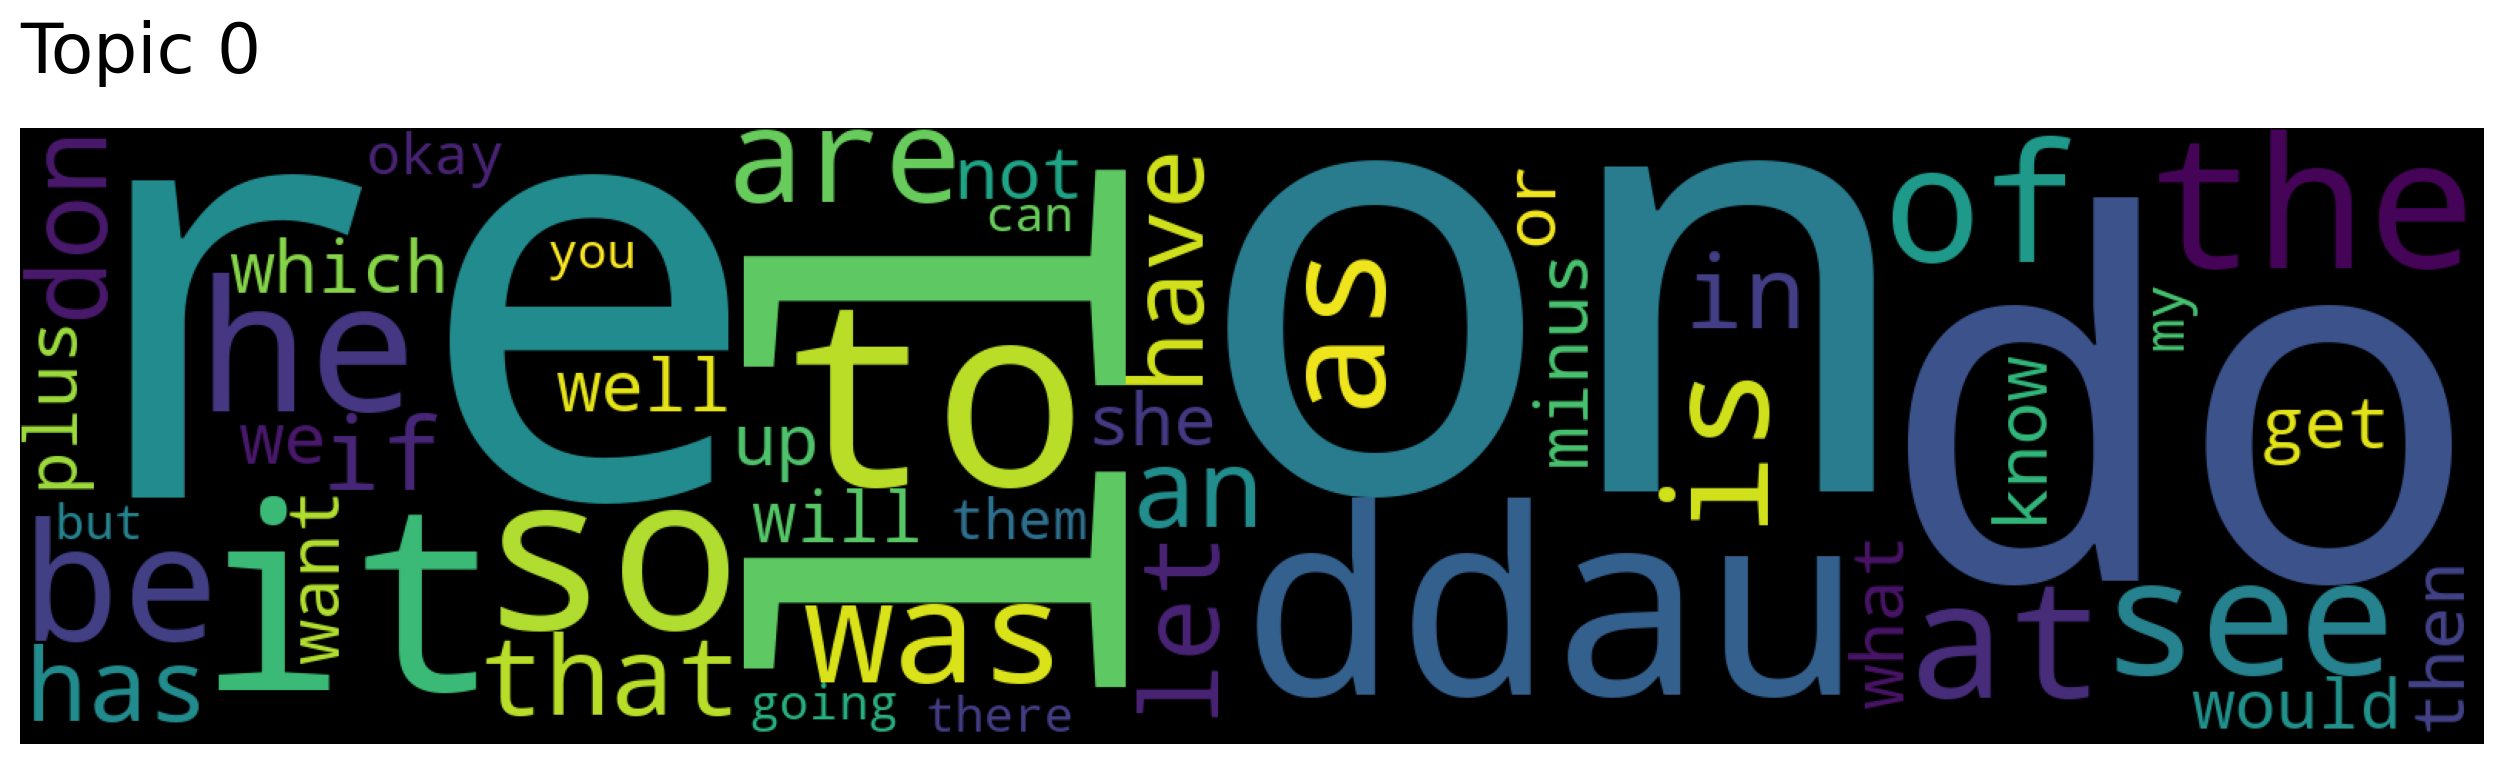

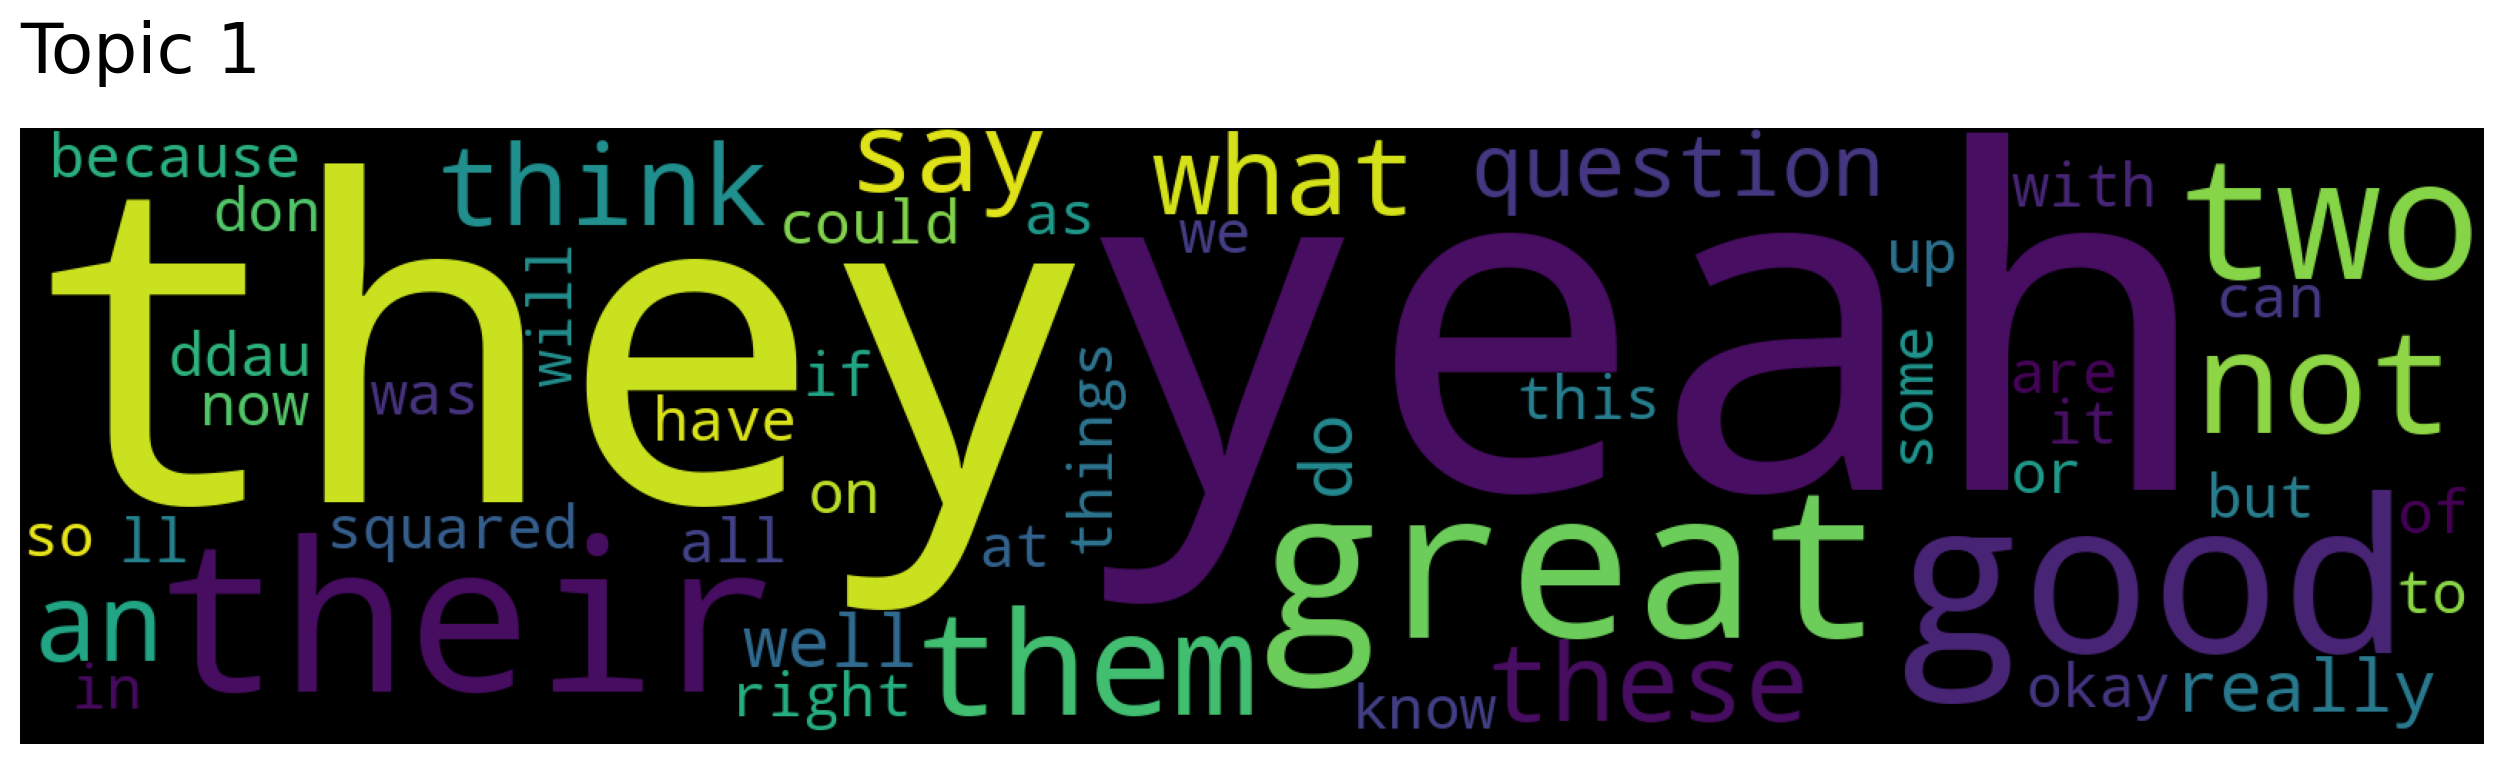

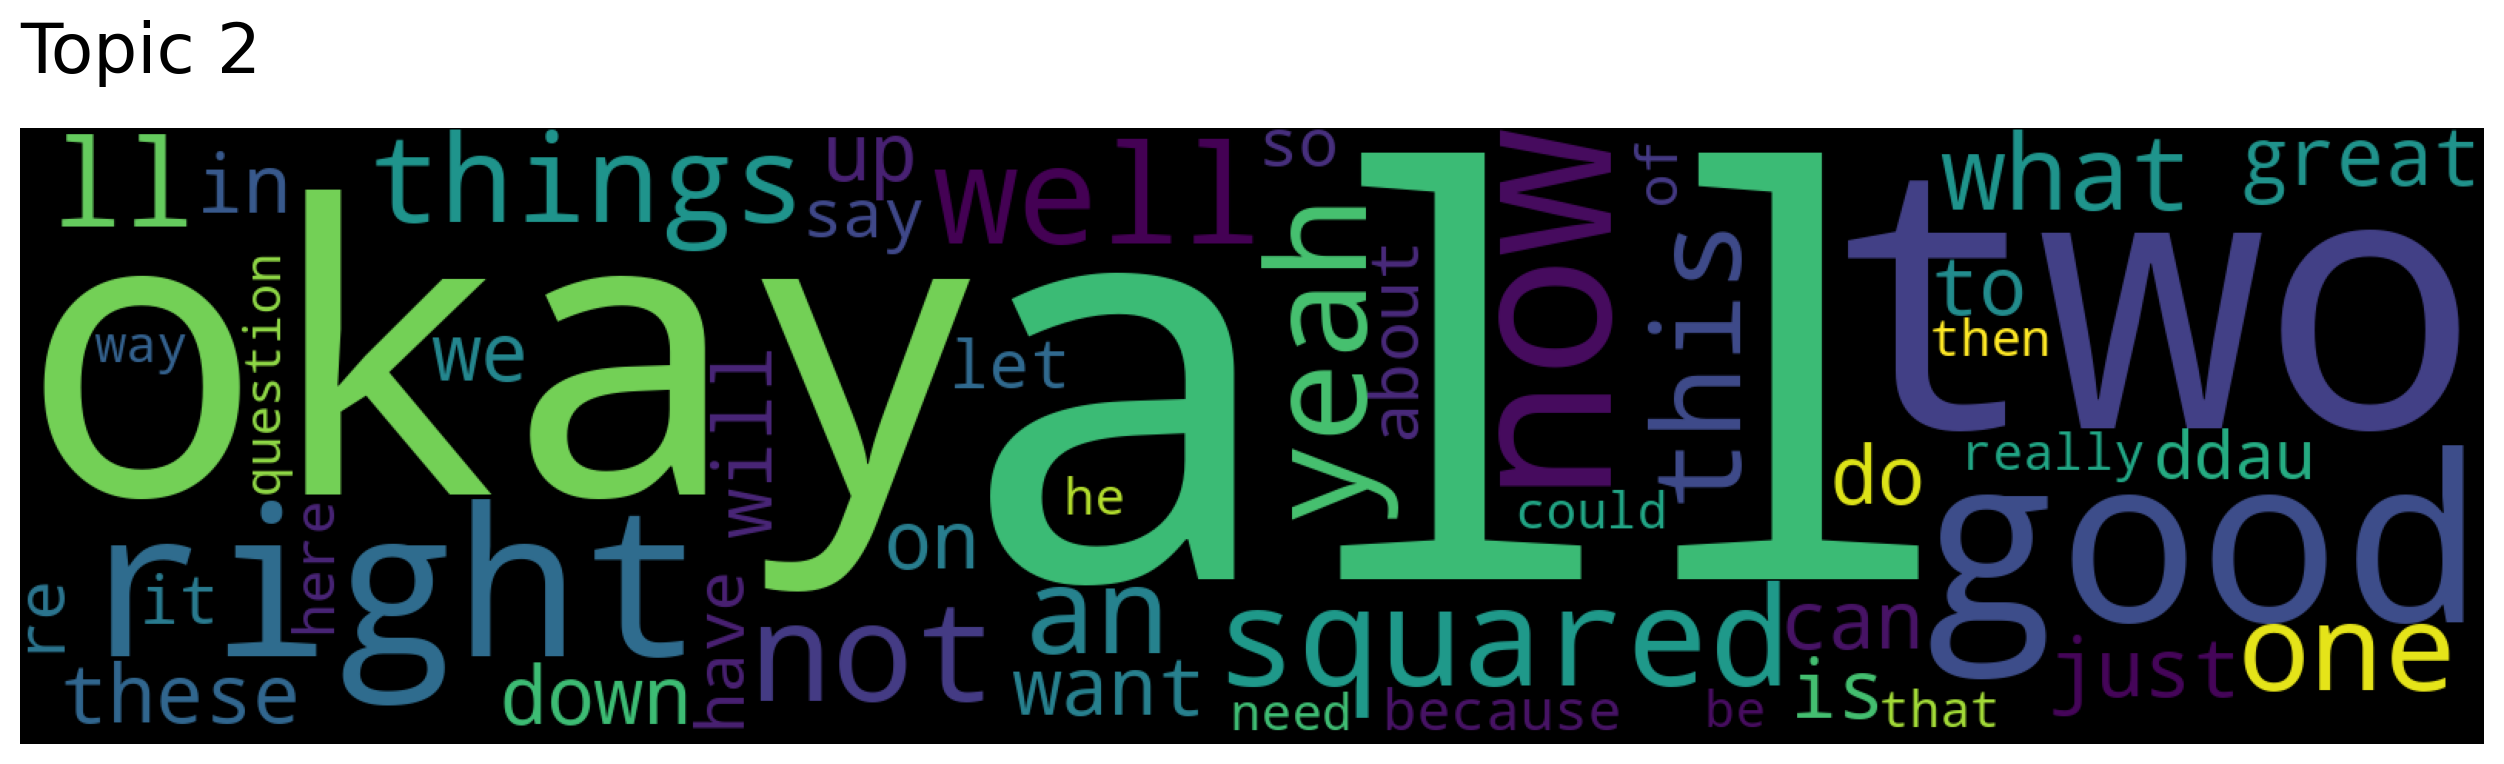

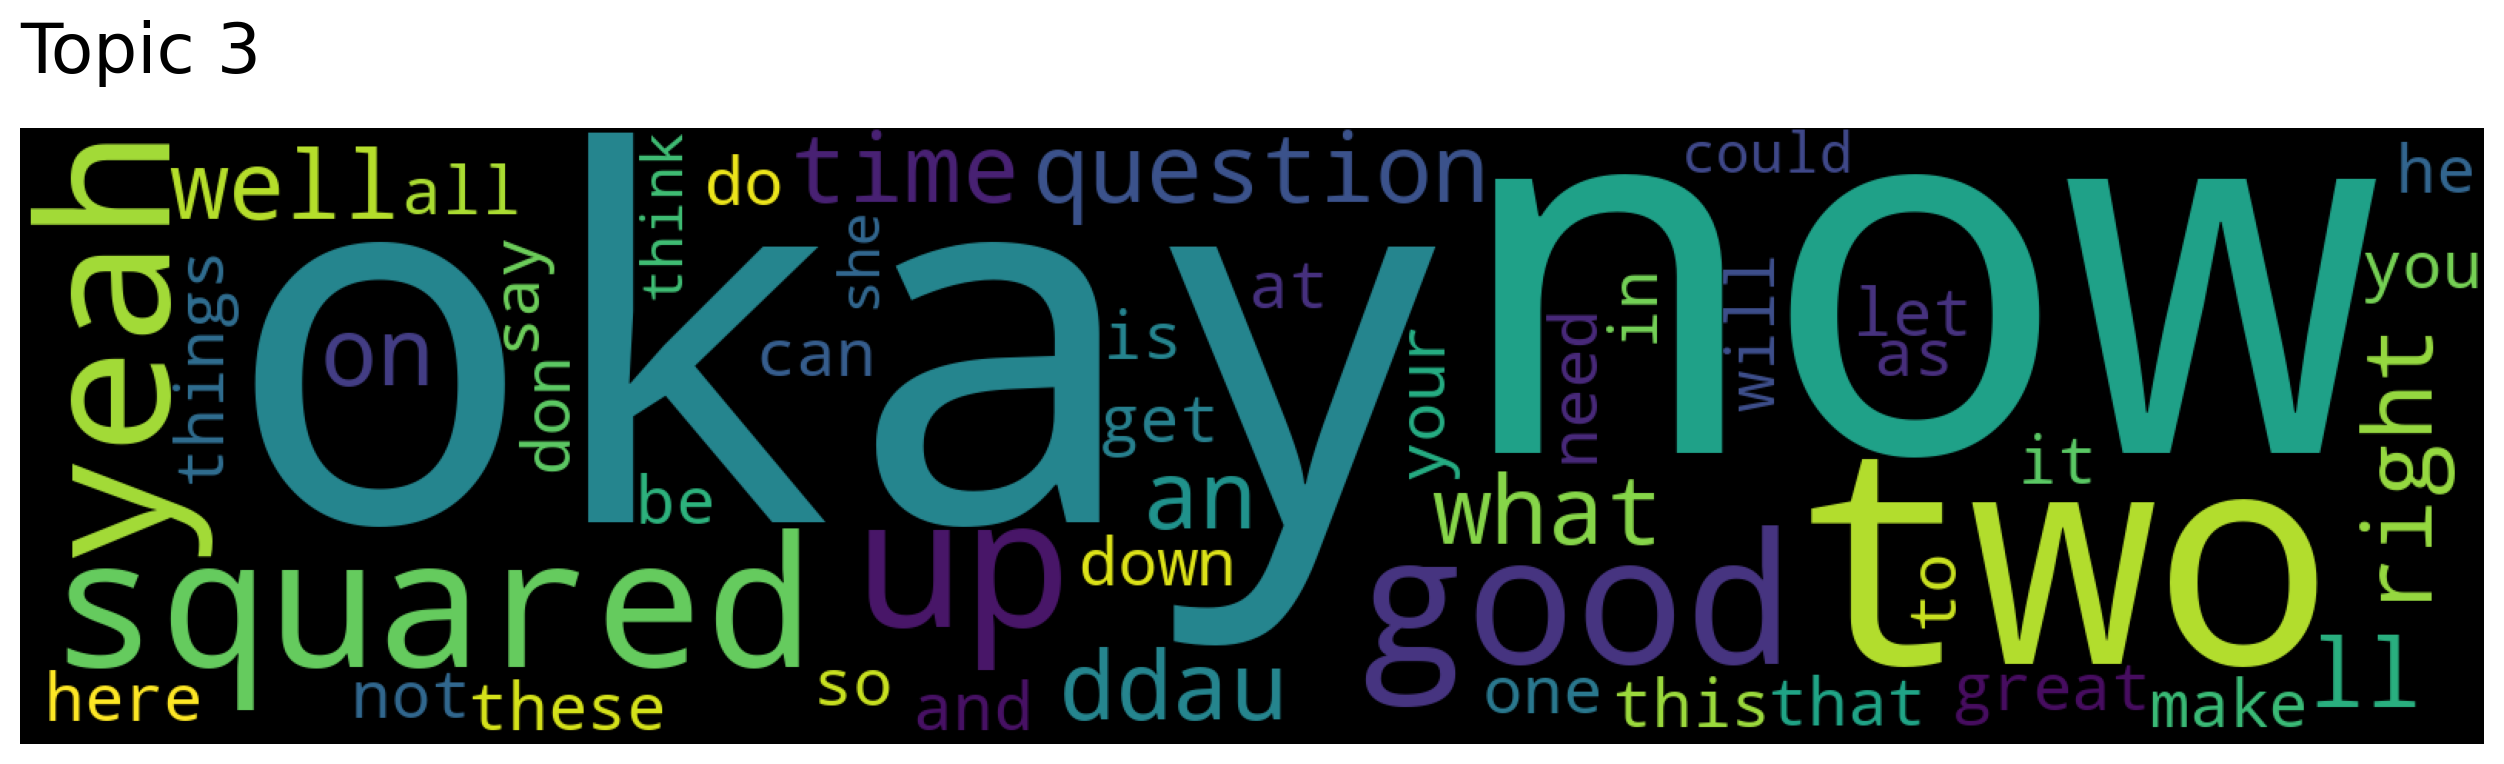

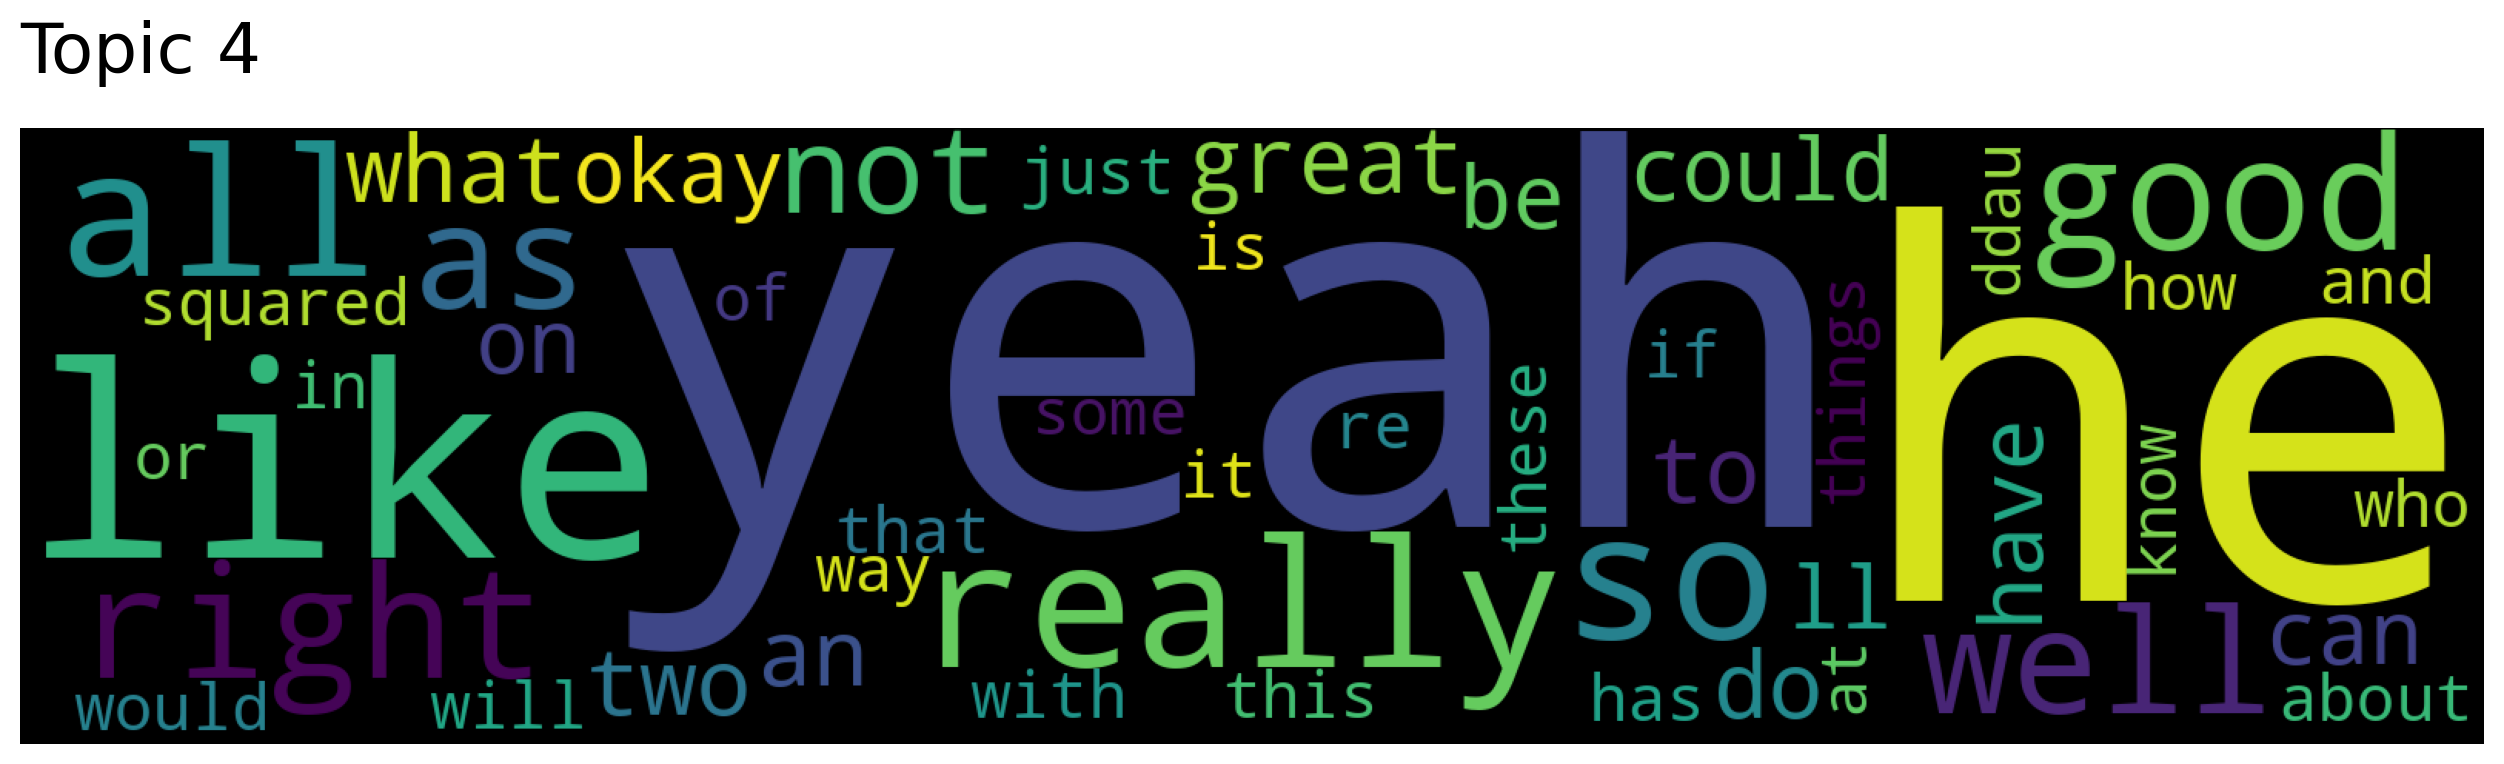

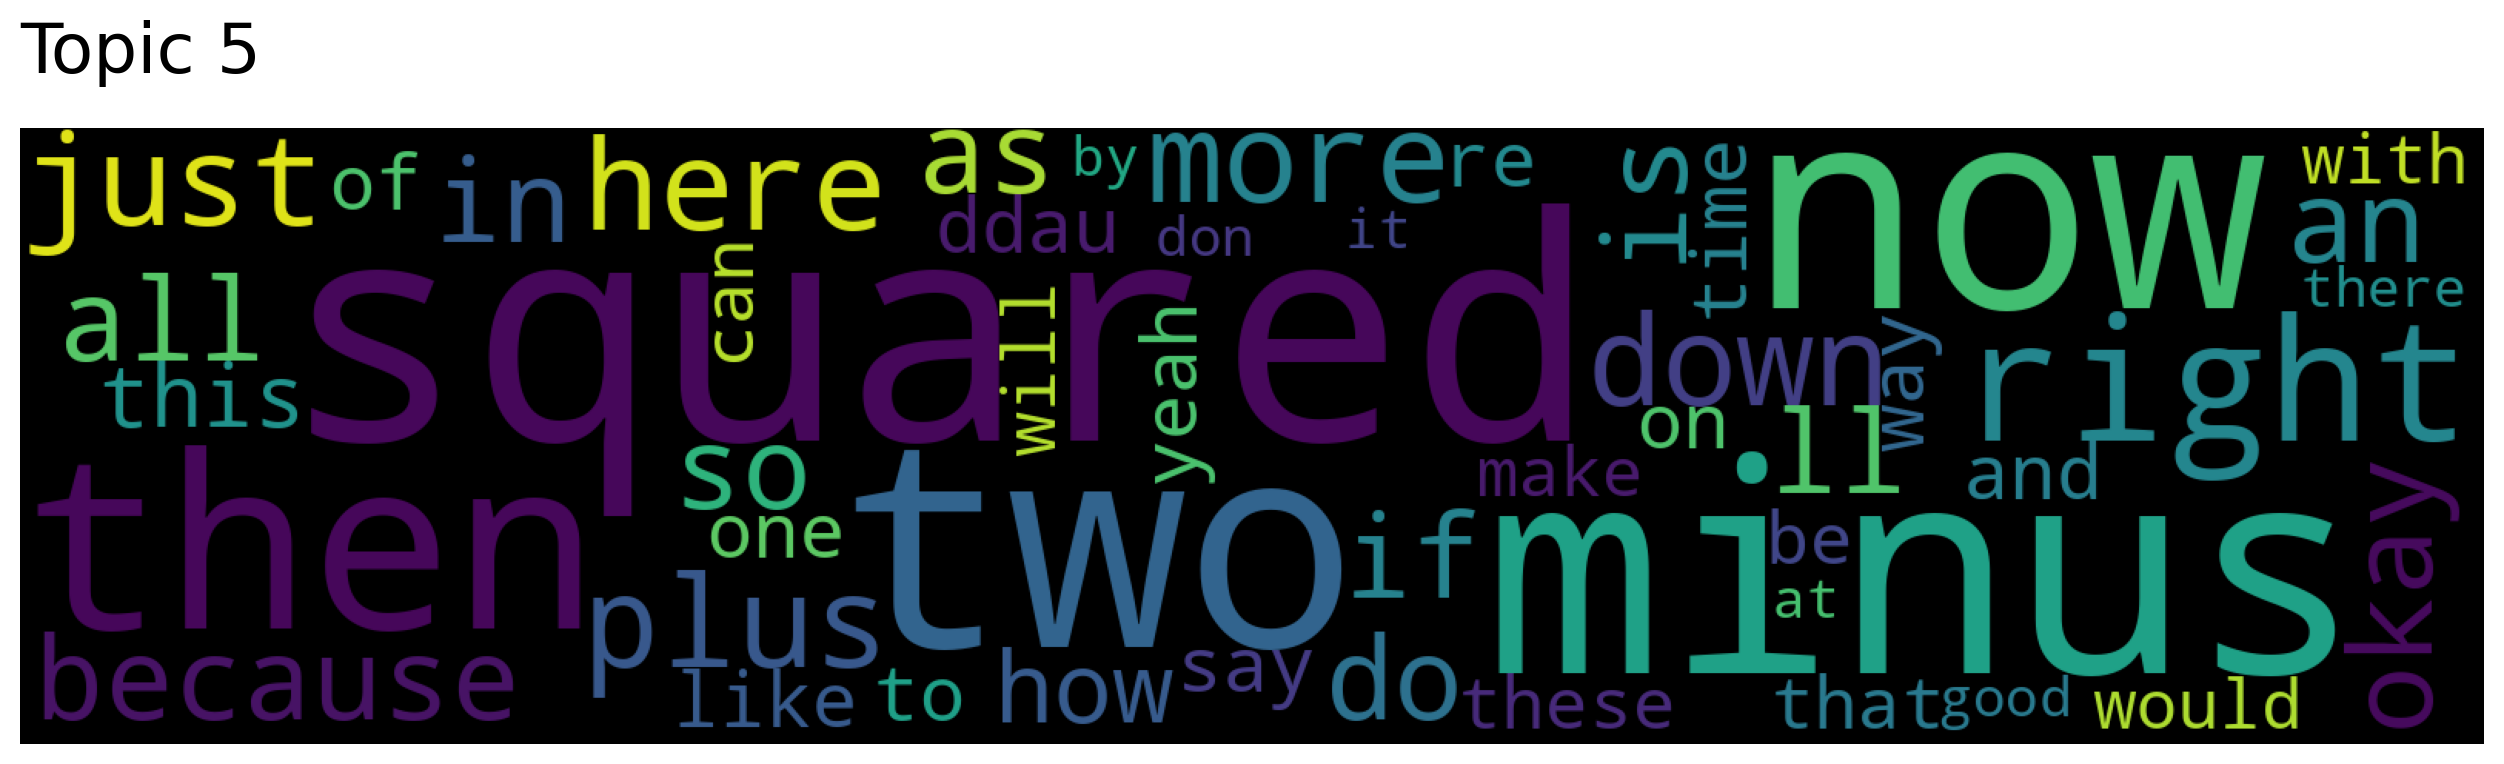

In [8]:
from top2vec import Top2Vec

docs_split = []
m = 0
for x in df["Texts"].to_list():
    m = max(m,len(x))

doc_length = m*10

for doc in  df["Texts"].to_list():
    skip_n = 512
    for i in range(0,doc_length,skip_n):
        docs_split.append(doc[i:i+skip_n])

model = Top2Vec(docs_split, workers=4, embedding_model='distiluse-base-multilingual-cased')

# topic_sizes, topic_nums = model.get_topic_sizes()
# print(topic_sizes)
# print(topic_nums)

n = model.get_num_topics()
try:
    topic_words,word_scores,topic_nums = model.get_topics(n)
    for topic in topic_nums:
        model.generate_topic_wordcloud(topic)
    for topic_words,word_scores,topic_nums in zip(topic_words,word_scores,topic_nums):
        print(topic_words)
except:
    print(f"No topic detected")